**Ejercicio 12: Multimodal Embeddings**


**Nombre:** Aarón Yumancela

**Objetivo de la práctica**


*   El objetivo de este ejercicio es observar cómo modelos multimodales como CLIP llevan texto e imágenes al mismo espacio vectorial, y verificar graficando embeddings en 2D.



**Instalación**

In [1]:
# Instalación de dependencias necesarias
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 730.6 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ej4a9m30
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ej4a9m30
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=0eefe2a47ebc84ce8a4baa8c27e4a4b366e4174d21d77cdfc3989e1b271f1c2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-70yooy4p/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


**Cargar modelo CLIP**

In [15]:
# Cargar modelo CLIP multimodal
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


**Definir textos y descargar imágenes**

In [16]:
# Definir textos y descargar imágenes
texts = [
    "perro",
    "gato",
    "auto",
    "comida",
    "mascota",
    "vehículo"
]


import urllib.request

image_urls = {
    "perro1.jpg": "https://images.unsplash.com/photo-1517423440428-a5a00ad493e8",
    "perro2.jpg": "https://images.unsplash.com/photo-1558788353-f76d92427f16",
    "gato1.jpg": "https://images.unsplash.com/photo-1518791841217-8f162f1e1131",
    "gato2.jpg": "https://images.unsplash.com/photo-1595433707802-6b2626ef1c91",
    "auto1.jpg": "https://images.unsplash.com/photo-1503376780353-7e6692767b70",
    "auto2.jpg": "https://images.unsplash.com/photo-1549924231-f129b911e442",
    "comida1.jpg": "https://images.unsplash.com/photo-1546069901-ba9599a7e63c",
    "comida2.jpg": "https://images.unsplash.com/photo-1504674900247-0877df9cc836"
}

image_paths = []

for name, url in image_urls.items():
    urllib.request.urlretrieve(url + "?w=640", name)
    image_paths.append("/content/" + name)

len(image_paths)


8

**Obtener embeddings**

In [17]:
# Obtener embeddings de texto e imagen
# Text embeddings
text_tokens = clip.tokenize(texts).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)

# Image embeddings
images = [preprocess(Image.open(p)).unsqueeze(0) for p in image_paths]
images = torch.cat(images).to(device)

with torch.no_grad():
    image_embeddings = model.encode_image(images)


In [18]:
# Verificar mismo espacio vectorial
print("Text embeddings:", text_embeddings.shape)
print("Image embeddings:", image_embeddings.shape)


Text embeddings: torch.Size([6, 512])
Image embeddings: torch.Size([8, 512])


In [19]:
# Normalización para cosine similarity
text_embeddings = text_embeddings / text_embeddings.norm(dim=1, keepdim=True)
image_embeddings = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)


In [20]:
# Proyección de embeddings a 2D
import numpy as np
from sklearn.decomposition import PCA

all_embeddings = torch.cat([text_embeddings, image_embeddings]).cpu().numpy()

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings)


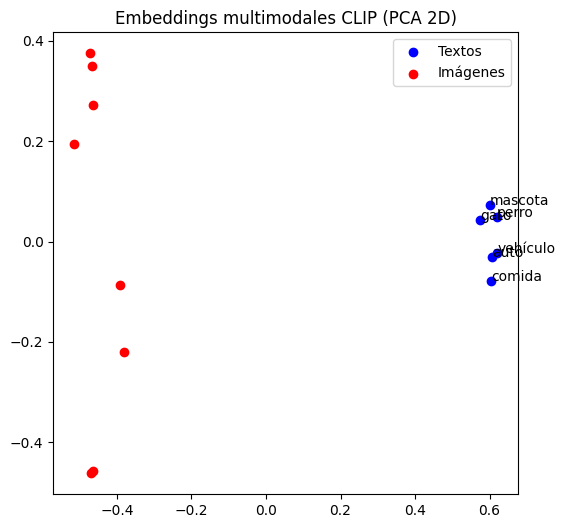

In [21]:
# Visualización 2D de embeddings
import matplotlib.pyplot as plt

n = len(texts)

plt.figure(figsize=(6,6))
plt.scatter(embeddings_2d[:n,0], embeddings_2d[:n,1], c='blue', label="Textos")
plt.scatter(embeddings_2d[n:,0], embeddings_2d[n:,1], c='red', label="Imágenes")

for i, txt in enumerate(texts):
    plt.text(embeddings_2d[i,0], embeddings_2d[i,1], txt)

plt.legend()
plt.title("Embeddings multimodales CLIP (PCA 2D)")
plt.show()


In [22]:
# Búsqueda texto a imagen
from sklearn.metrics.pairwise import cosine_similarity

sim_text_image = cosine_similarity(
    text_embeddings.cpu(),
    image_embeddings.cpu()
)

for i, text in enumerate(texts):
    best_img = sim_text_image[i].argmax()
    print(f"Texto '{text}' → Imagen '{image_paths[best_img]}' (cos={sim_text_image[i][best_img]:.3f})")


Texto 'perro' → Imagen '/content/perro1.jpg' (cos=0.257)
Texto 'gato' → Imagen '/content/gato2.jpg' (cos=0.260)
Texto 'auto' → Imagen '/content/auto1.jpg' (cos=0.236)
Texto 'comida' → Imagen '/content/comida1.jpg' (cos=0.222)
Texto 'mascota' → Imagen '/content/perro1.jpg' (cos=0.246)
Texto 'vehículo' → Imagen '/content/perro1.jpg' (cos=0.213)


In [23]:
# Búsqueda imagen a texto
sim_image_text = cosine_similarity(
    image_embeddings.cpu(),
    text_embeddings.cpu()
)

for i, img in enumerate(image_paths):
    best_text = sim_image_text[i].argmax()
    print(f"Imagen '{img}' → Texto '{texts[best_text]}' (cos={sim_image_text[i][best_text]:.3f})")


Imagen '/content/perro1.jpg' → Texto 'perro' (cos=0.257)
Imagen '/content/perro2.jpg' → Texto 'perro' (cos=0.242)
Imagen '/content/gato1.jpg' → Texto 'gato' (cos=0.257)
Imagen '/content/gato2.jpg' → Texto 'gato' (cos=0.260)
Imagen '/content/auto1.jpg' → Texto 'auto' (cos=0.236)
Imagen '/content/auto2.jpg' → Texto 'auto' (cos=0.208)
Imagen '/content/comida1.jpg' → Texto 'comida' (cos=0.222)
Imagen '/content/comida2.jpg' → Texto 'comida' (cos=0.219)


In [25]:
# Búsqueda libre texto-imagen
def buscar_imagen(texto):
    text_token = clip.tokenize([texto]).to(device)
    with torch.no_grad():
        text_emb = model.encode_text(text_token)
    text_emb = text_emb / text_emb.norm(dim=1, keepdim=True)

    sims = cosine_similarity(text_emb.cpu(), image_embeddings.cpu())[0]
    best_idx = sims.argmax()

    print(f"Texto: {texto}")
    print(f"Imagen más similar: {image_paths[best_idx]}")


In [26]:
# Pruebas de búsqueda semántica
buscar_imagen("motor")
buscar_imagen("mascota")
buscar_imagen("comida")


Texto: motor
Imagen más similar: /content/auto1.jpg
Texto: mascota
Imagen más similar: /content/perro1.jpg
Texto: comida
Imagen más similar: /content/comida1.jpg
